# AlphaFold2_advanced

Contact: Laura Cooper, camdu@warwick.ac.uk

This notebook is a modified version of [YoshitakaMo's localcolabfold](https://github.com/YoshitakaMo/localcolabfold) runner.py file, which is based on the AlphaFold2_advanced notebook from [sokrypton/ColabFold](https://github.com/sokrypton/ColabFold). Where possible the format of the notebook has been copied from the Google Colab version. 

To run the notebook, run each cell in turn. Select the cell, and the either press the "Run" button above or press "Shift+Enter". Please don't edit the content of the cells (unless you know what you are doing).

### Edited notes from sokrypton/ColabFold/AlphaFold2_advanced.ipynb:
This notebook modifies deepmind's original notebook to add experimental support for modeling complexes (both homo and hetero-oligomers), option to run MMseqs2 instead of Jackhmmer for MSA generation and advanced functionality.

See ColabFold for other related notebooks.

Limitations:

- This notebook does NOT use Templates.
- Can I use the models for Molecular Replacement? Yes, but be CAREFUL, the bfactor column is populated with pLDDT confidence values (higher = better). Phenix.phaser expects a "real" bfactor, where (lower = better). See post from Claudia Millán on how to process models.


## Install software

In [36]:
#%%
import os
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

import jax

from IPython.utils import io
import subprocess
import tqdm.notebook

# --- Python imports ---
import colabfold as cf
import pairmsa
import sys
import pickle

from urllib import request
from concurrent import futures
import json
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol

from urllib import request
from concurrent import futures
import json
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol

from alphafold.model import model
from alphafold.model import config
from alphafold.model import data

from alphafold.data import parsers
from alphafold.data import pipeline
from alphafold.data.tools import jackhmmer

from alphafold.common import protein

# --- Additional Imports ---
import ipywidgets as widgets
lo=widgets.Layout(width='100%')
sty={'description_width': '100px'}

### Check your OS for localcolabfold
import platform
pf = platform.system()
if pf == 'Windows':
  print('ColabFold on Windows')
elif pf == 'Darwin':
  print('ColabFold on Mac')
  device="cpu"
elif pf == 'Linux':
  print('ColabFold on Linux')
  device="gpu"
#%%

def run_jackhmmer(sequence, prefix):

  fasta_path = f"{prefix}.fasta"
  with open(fasta_path, 'wt') as f:
    f.write(f'>query\n{sequence}')

  pickled_msa_path = f"{prefix}.jackhmmer.pickle"
  if os.path.isfile(pickled_msa_path):
    msas_dict = pickle.load(open(pickled_msa_path,"rb"))
    msas, deletion_matrices, names = (msas_dict[k] for k in ['msas', 'deletion_matrices', 'names'])
    full_msa = []
    for msa in msas:
      full_msa += msa
  else:
    # --- Find the closest source ---
    test_url_pattern = 'https://storage.googleapis.com/alphafold-colab{:s}/latest/uniref90_2021_03.fasta.1'
    ex = futures.ThreadPoolExecutor(3)
    def fetch(source):
      request.urlretrieve(test_url_pattern.format(source))
      return source
    fs = [ex.submit(fetch, source) for source in ['', '-europe', '-asia']]
    source = None
    for f in futures.as_completed(fs):
      source = f.result()
      ex.shutdown()
      break

    jackhmmer_binary_path = '/usr/bin/jackhmmer'
    dbs = []

    num_jackhmmer_chunks = {'uniref90': 59, 'smallbfd': 17, 'mgnify': 71}
    total_jackhmmer_chunks = sum(num_jackhmmer_chunks.values())
    with tqdm.notebook.tqdm(total=total_jackhmmer_chunks, bar_format=TQDM_BAR_FORMAT) as pbar:
      def jackhmmer_chunk_callback(i):
        pbar.update(n=1)

      pbar.set_description('Searching uniref90')
      jackhmmer_uniref90_runner = jackhmmer.Jackhmmer(
          binary_path=jackhmmer_binary_path,
          database_path=f'https://storage.googleapis.com/alphafold-colab{source}/latest/uniref90_2021_03.fasta',
          get_tblout=True,
          num_streamed_chunks=num_jackhmmer_chunks['uniref90'],
          streaming_callback=jackhmmer_chunk_callback,
          z_value=135301051)
      dbs.append(('uniref90', jackhmmer_uniref90_runner.query(fasta_path)))

      pbar.set_description('Searching smallbfd')
      jackhmmer_smallbfd_runner = jackhmmer.Jackhmmer(
          binary_path=jackhmmer_binary_path,
          database_path=f'https://storage.googleapis.com/alphafold-colab{source}/latest/bfd-first_non_consensus_sequences.fasta',
          get_tblout=True,
          num_streamed_chunks=num_jackhmmer_chunks['smallbfd'],
          streaming_callback=jackhmmer_chunk_callback,
          z_value=65984053)
      dbs.append(('smallbfd', jackhmmer_smallbfd_runner.query(fasta_path)))

      pbar.set_description('Searching mgnify')
      jackhmmer_mgnify_runner = jackhmmer.Jackhmmer(
          binary_path=jackhmmer_binary_path,
          database_path=f'https://storage.googleapis.com/alphafold-colab{source}/latest/mgy_clusters_2019_05.fasta',
          get_tblout=True,
          num_streamed_chunks=num_jackhmmer_chunks['mgnify'],
          streaming_callback=jackhmmer_chunk_callback,
          z_value=304820129)
      dbs.append(('mgnify', jackhmmer_mgnify_runner.query(fasta_path)))

    # --- Extract the MSAs and visualize ---
    # Extract the MSAs from the Stockholm files.
    # NB: deduplication happens later in pipeline.make_msa_features.

    mgnify_max_hits = 501
    msas = []
    deletion_matrices = []
    names = []
    for db_name, db_results in dbs:
      unsorted_results = []
      for i, result in enumerate(db_results):
        msa, deletion_matrix, target_names = parsers.parse_stockholm(result['sto'])
        e_values_dict = parsers.parse_e_values_from_tblout(result['tbl'])
        e_values = [e_values_dict[t.split('/')[0]] for t in target_names]
        zipped_results = zip(msa, deletion_matrix, target_names, e_values)
        if i != 0:
          # Only take query from the first chunk
          zipped_results = [x for x in zipped_results if x[2] != 'query']
        unsorted_results.extend(zipped_results)
      sorted_by_evalue = sorted(unsorted_results, key=lambda x: x[3])
      db_msas, db_deletion_matrices, db_names, _ = zip(*sorted_by_evalue)
      if db_msas:
        if db_name == 'mgnify':
          db_msas = db_msas[:mgnify_max_hits]
          db_deletion_matrices = db_deletion_matrices[:mgnify_max_hits]
          db_names = db_names[:mgnify_max_hits]
        msas.append(db_msas)
        deletion_matrices.append(db_deletion_matrices)
        names.append(db_names)
        msa_size = len(set(db_msas))
        print(f'{msa_size} Sequences Found in {db_name}')

      pickle.dump({"msas":msas,
                   "deletion_matrices":deletion_matrices,
                   "names":names}, open(pickled_msa_path,"wb"))
  return msas, deletion_matrices, names

ColabFold on Linux


## Enter the amino acid sequence to fold
Run the cell below and then you will be presented with boxes where you can enter the inputs.

In [37]:
# Create widgets to request user input
# Basic settings
query_sequence=widgets.Text(value='PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK',
                            description='sequence:',
                           layout=lo,style=sty)
query_job_name=widgets.Text(value='test',description='job name:',layout=lo,style=sty)
query_homooligomer=widgets.Text(value='1',description='homooligomer:',layout=lo,style=sty)
# Display widgets
display(query_sequence, query_job_name, query_homooligomer)

Text(value='PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK', description='sequence:', layout=Layo…

Text(value='test', description='job name:', layout=Layout(width='100%'), style=DescriptionStyle(description_wi…

Text(value='1', description='homooligomer:', layout=Layout(width='100%'), style=DescriptionStyle(description_w…

- `sequence` Specify protein sequence to be modelled.
    - Use `/` to specify intra-protein chainbreaks (for trimming regions within protein).
    - Use `:` to specify inter-protein chainbreaks (for modeling protein-protein hetero-complexes).
    - For example, sequence `AC/DE:FGH` will be modelled as polypeptides: `AC`, `DE` and `FGH`. A seperate MSA will be generates for `ACDE` and `FGH`. If `pair_msa` is enabled, `ACDE`'s MSA will be paired with `FGH`'s MSA.
- `homooligomer` Define number of copies in a homo-oligomeric assembly.
    - Use `:` to specify different homooligomeric state (copy numer) for each component of the complex.
    - For example, **sequence:**`ABC:DEF`, **homooligomer:** `2:1`, the first protein `ABC` will be modeled as a homodimer (2 copies) and second `DEF` a monomer (1 copy).

In [38]:
import re

# define sequence
sequence = query_sequence.value
sequence = re.sub("[^A-Z:/]", "", sequence.upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("/+","/",sequence)
sequence = re.sub("^[:/]+","",sequence)
sequence = re.sub("[:/]+$","",sequence)

jobname = query_job_name.value
jobname = re.sub(r'\W+', '', jobname)

# define number of copies
homooligomer = query_homooligomer.value
homooligomer = re.sub("[:/]+",":",homooligomer)
homooligomer = re.sub("^[:/]+","",homooligomer)
homooligomer = re.sub("[:/]+$","",homooligomer)

if len(homooligomer) == 0: homooligomer = "1"
homooligomer = re.sub("[^0-9:]", "", homooligomer)
homooligomers = [int(h) for h in homooligomer.split(":")]



ori_sequence = sequence
sequence = sequence.replace("/","").replace(":","")
seqs = ori_sequence.replace("/","").split(":")

if len(seqs) != len(homooligomers):
  if len(homooligomers) == 1:
    homooligomers = [homooligomers[0]] * len(seqs)
    homooligomer = ":".join([str(h) for h in homooligomers])
  else:
    while len(seqs) > len(homooligomers):
      homooligomers.append(1)
    homooligomers = homooligomers[:len(seqs)]
    homooligomer = ":".join([str(h) for h in homooligomers])
    print("WARNING: Mismatch between number of breaks ':' in 'sequence' and 'homooligomer' definition")

full_sequence = "".join([s*h for s,h in zip(seqs,homooligomers)])

# prediction directory
output_dir = 'prediction_' + jobname + '_' + cf.get_hash(full_sequence)[:5]
os.makedirs(output_dir, exist_ok=True)
# delete existing files in working directory
for f in os.listdir(output_dir):
  os.remove(os.path.join(output_dir, f))

MIN_SEQUENCE_LENGTH = 16
MAX_SEQUENCE_LENGTH = 2500

aatypes = set('ACDEFGHIKLMNPQRSTVWY')  # 20 standard aatypes
if not set(full_sequence).issubset(aatypes):
  raise Exception(f'Input sequence contains non-amino acid letters: {set(sequence) - aatypes}. AlphaFold only supports 20 standard amino acids as inputs.')
if len(full_sequence) < MIN_SEQUENCE_LENGTH:
  raise Exception(f'Input sequence is too short: {len(full_sequence)} amino acids, while the minimum is {MIN_SEQUENCE_LENGTH}')
if len(full_sequence) > MAX_SEQUENCE_LENGTH:
  raise Exception(f'Input sequence is too long: {len(full_sequence)} amino acids, while the maximum is {MAX_SEQUENCE_LENGTH}. Please use the full AlphaFold system for long sequences.')

if len(full_sequence) > 1400:
  print(f"WARNING: For a typical Google-Colab-GPU (16G) session, the max total length is ~1400 residues. You are at {len(full_sequence)}! Run Alphafold may crash.")

print(f"homooligomer: '{homooligomer}'")
print(f"total_length: '{len(full_sequence)}'")
print(f"working_directory: '{output_dir}'")

homooligomer: '1'
total_length: '59'
working_directory: 'prediction_test_a5e17'


## Search against genetic databases
Run the cell below and then you will be presented with boxes where you can enter the inputs.

In [40]:
# msa method
query_msa_method=widgets.HBox([widgets.Label('msa_method:',style=sty),widgets.Dropdown(
    options=["mmseqs2","jackhmmer","single_sequence","precomputed"], 
    value="mmseqs2", 
    decription="msa mode:",
    ensure_option=True,
    layout=widgets.Layout(width='60%'))])

# custom msa options
query_add_custom_msa=widgets.Checkbox(value=False, description="add_custom_msa",indent=False)
query_msa_format=widgets.HBox([widgets.Label('msa_format',style=sty),widgets.Dropdown(
    options=["fas","a2m","a3m","sto","psi","clu"], 
    value="fas", 
    decription="msa_format",
    ensure_option=True,
    layout=widgets.Layout(width='60%'))])

#use_amber=widgets.Checkbox(value=False, description="Use amber",indent=False)
query_pair_msa=widgets.Checkbox(value=False, description="pair_msa",indent=False)
query_include_unpaired_msa=widgets.Checkbox(value=True, description="include_unpaired_msa",indent=False)
# At some point change this to have three options like the ColabFold version:
#@markdown Experimental option for protein complexes. Pairing currently only supported for proteins in same operon (prokaryotic genomes).
#pair_mode = "unpaired" #@param ["unpaired","unpaired+paired","paired"] {type:"string"}
#@markdown - `unpaired` - generate seperate MSA for each protein.
#@markdown - `unpaired+paired` - attempt to pair sequences from the same operon within the genome. 
#@markdown - `paired` - only use sequences that were sucessfully paired.

query_pair_cov=widgets.HBox([widgets.Label('pair_cov:',style=sty),widgets.Dropdown(
    options=[50,75,90], 
    value=50, 
    decription='pair_cov:',
    ensure_option=True,
    layout=widgets.Layout(width='60%'))])
# At some point change this to have three options like the ColabFold version:
# pair_cov = 50 #@param [0,25,50,75,90] {type:"raw"}

query_pair_qid=widgets.HBox([widgets.Label('pair_qid:',style=sty),widgets.Dropdown(
    options=[15,20,30,40,50] , 
    value=20, 
    decription='pair_qid:',
    ensure_option=True,
    layout=widgets.Layout(width='60%'))])
# At some point change this to have three options like the ColabFold version:
# pair_qid = 20 #@param [0,15,20,30,40,50] {type:"raw"}

display(query_msa_method, query_add_custom_msa, query_msa_format, query_pair_msa, query_include_unpaired_msa, query_pair_cov, query_pair_qid)

Checkbox(value=False, description='add_custom_msa', indent=False)

Checkbox(value=False, description='pair_msa', indent=False)

Checkbox(value=True, description='include_unpaired_msa', indent=False)

#### msa_method
- `mmseqs2` - FAST method from [ColabFold](https://github.com/sokrypton/ColabFold)
- `jackhmmer` - default method from Deepmind (SLOW, but may find more/less sequences).
- `single_sequence` - use single sequence input
- `precomputed` If you have previously run this notebook and saved the results, you can skip this step by uploading the previously generated  `prediction_?????/msa.pickle`

#### Custom msa options
- `add_custom_msa` - If enabled, you'll get an option to upload your custom MSA in the specified `msa_format`. Note: Your MSA will be supplemented with those from 'mmseqs2' or 'jackhmmer', unless `msa_method` is set to 'single_sequence'.

#### Options to prefilter each MSA before pairing. (It might help if there are any paralogs in the complex.)
- `pair_cov` prefilter each MSA to minimum coverage with query (%) before pairing.
- `pair_qid` prefilter each MSA to minimum sequence identity with query (%) before pairing.

Once the following cell has been executed, you will see
statistics about the multiple sequence alignment
(MSA) that will be used by AlphaFold. In particular,
you’ll see how well each residue is covered by similar
sequences in the MSA.
(Note that the search against databases and the actual prediction can take some time, from minutes to hours, depending on the length of the protein and what type of GPU you are allocated by Colab.)

running mmseqs2


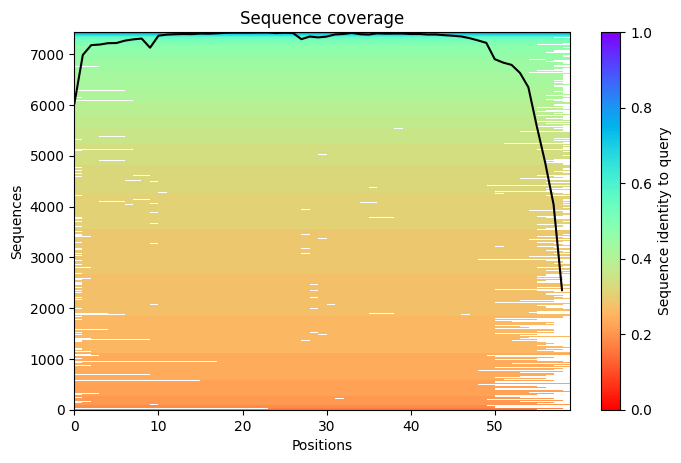

In [41]:
#%%
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

msa_method = query_msa_method.children[1].value

pair_msa = query_pair_msa.value
pair_cov = query_pair_cov.children[1].value
pair_qid = query_pair_qid.children[1].value
include_unpaired_msa = query_include_unpaired_msa.value

add_custom_msa = query_add_custom_msa.value
msa_format = query_msa_format.children[1].value

# --- Search against genetic databases ---
os.makedirs('tmp', exist_ok=True)
msas, deletion_matrices = [],[]

if add_custom_msa:
  print(f"upload custom msa in '{msa_format}' format")
  msa_dict = files.upload()
  lines = msa_dict[list(msa_dict.keys())[0]].decode()

  # convert to a3m
  with open(f"tmp/upload.{msa_format}","w") as tmp_upload:
    tmp_upload.write(lines)
  os.system(f"reformat.pl {msa_format} a3m tmp/upload.{msa_format} tmp/upload.a3m")
  a3m_lines = open("tmp/upload.a3m","r").read()

  # parse
  msa, mtx = parsers.parse_a3m(a3m_lines)
  msas.append(msa)
  deletion_matrices.append(mtx)

  if len(msas[0][0]) != len(sequence):
    raise ValueError("ERROR: the length of msa does not match input sequence")

if msa_method == "precomputed":
  print("upload precomputed pickled msa from previous run")
  pickled_msa_dict = files.upload()
  msas_dict = pickle.loads(pickled_msa_dict[list(pickled_msa_dict.keys())[0]])
  msas, deletion_matrices = (msas_dict[k] for k in ['msas', 'deletion_matrices'])

elif msa_method == "single_sequence":
  if len(msas) == 0:
    msas.append([sequence])
    deletion_matrices.append([[0]*len(sequence)])

else:
  seqs = ori_sequence.replace('/','').split(':')
  _blank_seq = ["-" * len(seq) for seq in seqs]
  _blank_mtx = [[0] * len(seq) for seq in seqs]
  def _pad(ns,vals,mode):
    if mode == "seq": _blank = _blank_seq.copy()
    if mode == "mtx": _blank = _blank_mtx.copy()
    if isinstance(ns, list):
      for n,val in zip(ns,vals): _blank[n] = val
    else: _blank[ns] = vals
    if mode == "seq": return "".join(_blank)
    if mode == "mtx": return sum(_blank,[])

  if len(seqs) == 1 or "unpaired" in pair_mode:
    # gather msas
    if msa_method == "mmseqs2":
      prefix = cf.get_hash("".join(seqs))
      prefix = os.path.join('tmp',prefix)
      print(f"running mmseqs2")
      A3M_LINES = cf.run_mmseqs2(seqs, prefix, filter=True)

    for n, seq in enumerate(seqs):
      # tmp directory
      prefix = cf.get_hash(seq)
      prefix = os.path.join('tmp',prefix)

      if msa_method == "mmseqs2":
        # run mmseqs2
        a3m_lines = A3M_LINES[n]
        msa, mtx = parsers.parse_a3m(a3m_lines)
        msas_, mtxs_ = [msa],[mtx]

      elif msa_method == "jackhmmer":
        print(f"running jackhmmer on seq_{n}")
        # run jackhmmer
        msas_, mtxs_, names_ = ([sum(x,())] for x in run_jackhmmer(seq, prefix))

      # pad sequences
      for msa_,mtx_ in zip(msas_,mtxs_):
        msa,mtx = [sequence],[[0]*len(sequence)]
        for s,m in zip(msa_,mtx_):
          msa.append(_pad(n,s,"seq"))
          mtx.append(_pad(n,m,"mtx"))

        msas.append(msa)
        deletion_matrices.append(mtx)

  ####################################################################################
  # PAIR_MSA
  ####################################################################################

  if len(seqs) > 1 and (pair_mode == "paired" or pair_mode == "unpaired+paired"):
    print("attempting to pair some sequences...")

    if msa_method == "mmseqs2":
      prefix = cf.get_hash("".join(seqs))
      prefix = os.path.join('tmp',prefix)
      print(f"running mmseqs2_noenv_nofilter on all seqs")
      A3M_LINES = cf.run_mmseqs2(seqs, prefix, use_env=False, use_filter=False)

    _data = []
    for a in range(len(seqs)):
      print(f"prepping seq_{a}")
      _seq = seqs[a]
      _prefix = os.path.join('tmp',cf.get_hash(_seq))

      if msa_method == "mmseqs2":
        a3m_lines = A3M_LINES[a]
        _msa, _mtx, _lab = pairmsa.parse_a3m(a3m_lines,
                                             filter_qid=pair_qid/100,
                                             filter_cov=pair_cov/100)

      elif msa_method == "jackhmmer":
        _msas, _mtxs, _names = run_jackhmmer(_seq, _prefix)
        _msa, _mtx, _lab = pairmsa.get_uni_jackhmmer(_msas[0], _mtxs[0], _names[0],
                                                     filter_qid=pair_qid/100,
                                                     filter_cov=pair_cov/100)

      if len(_msa) > 1:
        _data.append(pairmsa.hash_it(_msa, _lab, _mtx, call_uniprot=False))
      else:
        _data.append(None)

    Ln = len(seqs)
    O = [[None for _ in seqs] for _ in seqs]
    for a in range(Ln):
      if _data[a] is not None:
        for b in range(a+1,Ln):
          if _data[b] is not None:
            print(f"attempting pairwise stitch for {a} {b}")
            O[a][b] = pairmsa._stitch(_data[a],_data[b])
            _seq_a, _seq_b, _mtx_a, _mtx_b = (*O[a][b]["seq"],*O[a][b]["mtx"])

            ##############################################
            # filter to remove redundant sequences
            ##############################################
            ok = []
            with open("tmp/tmp.fas","w") as fas_file:
              fas_file.writelines([f">{n}\n{a+b}\n" for n,(a,b) in enumerate(zip(_seq_a,_seq_b))])
            os.system("hhfilter -maxseq 1000000 -i tmp/tmp.fas -o tmp/tmp.id90.fas -id 90")
            for line in open("tmp/tmp.id90.fas","r"):
              if line.startswith(">"): ok.append(int(line[1:]))
            ##############################################
            print(f"found {len(_seq_a)} pairs ({len(ok)} after filtering)")

            if len(_seq_a) > 0:
              msa,mtx = [sequence],[[0]*len(sequence)]
              for s_a,s_b,m_a,m_b in zip(_seq_a, _seq_b, _mtx_a, _mtx_b):
                msa.append(_pad([a,b],[s_a,s_b],"seq"))
                mtx.append(_pad([a,b],[m_a,m_b],"mtx"))
              msas.append(msa)
              deletion_matrices.append(mtx)

    '''
    # triwise stitching (WIP)
    if Ln > 2:
      for a in range(Ln):
        for b in range(a+1,Ln):
          for c in range(b+1,Ln):
            if O[a][b] is not None and O[b][c] is not None:
              print(f"attempting triwise stitch for {a} {b} {c}")
              list_ab = O[a][b]["lab"][1]
              list_bc = O[b][c]["lab"][0]
              msa,mtx = [sequence],[[0]*len(sequence)]
              for i,l_b in enumerate(list_ab):
                if l_b in list_bc:
                  j = list_bc.index(l_b)
                  s_a = O[a][b]["seq"][0][i]
                  s_b = O[a][b]["seq"][1][i]
                  s_c = O[b][c]["seq"][1][j]

                  m_a = O[a][b]["mtx"][0][i]
                  m_b = O[a][b]["mtx"][1][i]
                  m_c = O[b][c]["mtx"][1][j]

                  msa.append(_pad([a,b,c],[s_a,s_b,s_c],"seq"))
                  mtx.append(_pad([a,b,c],[m_a,m_b,m_c],"mtx"))
              if len(msa) > 1:
                msas.append(msa)
                deletion_matrices.append(mtx)
                print(f"found {len(msa)} triplets")
    '''
####################################################################################
####################################################################################

# save MSA as pickle
pickle.dump({"msas":msas,"deletion_matrices":deletion_matrices},
            open(os.path.join(output_dir,"msa.pickle"),"wb"))

make_msa_plot = len(msas[0]) > 1
if make_msa_plot:
  plt = cf.plot_msas(msas, ori_sequence)
  plt.savefig(os.path.join(output_dir,"msa_coverage.png"), bbox_inches = 'tight', dpi=300)
#%%

## Run Alphafold
Run the cell below and then you will be presented with boxes where you can enter the inputs.

In [49]:
query_rank_by=widgets.HBox([widgets.Label('rank_by:',style=sty),widgets.Dropdown(
    options=["pLDDT","pTMscore"],
    value="pLDDT", 
    decription='rank_by:',
    ensure_option=True,
    layout=widgets.Layout(width='60%'))])

query_use_turbo = widgets.Checkbox(value=True, description="use_turbo",indent=False)

query_max_msa=widgets.HBox([widgets.Label('max_msa:',style=sty),widgets.Dropdown(
    options=["512:1024", "256:512", "128:256", "64:128", "32:64"],
    value="512:1024", 
    decription='max_msa:',
    ensure_option=True,
    layout=widgets.Layout(width='60%'))])

#Make this an option - currently always true
#query_show_images = widgets.Checkbox(value=True, description="use_turbo",indent=False)
#@markdown - `show_images` To make things more exciting we show images of the predicted structures as they are being generated. (WARNING: the order of images displayed does not reflect any ranking).

display(query_rank_by, query_use_turbo, query_max_msa)


query_num_models = widgets.HBox([widgets.Label('max_msa:',style=sty),widgets.Dropdown(
    options=[1,2,3,4,5],
    value=5, 
    decription='max_msa:',
    ensure_option=True,
    layout=widgets.Layout(width='60%'))])

query_use_ptm = widgets.Checkbox(value=True, description="use_ptm",indent=False)
query_num_ensemble = widgets.HBox([widgets.Label('num_ensemble:',style=sty),widgets.Dropdown(
    options=[1,8],
    value=1, 
    decription='num_ensemble:',
    ensure_option=True,
    layout=widgets.Layout(width='60%'))])
query_max_recycles = widgets.HBox([widgets.Label('max_recycles:',style=sty),widgets.Dropdown(
    options=[1,3,6,12,24,48],
    value=3, 
    decription='max_recycles:',
    ensure_option=True,
    layout=widgets.Layout(width='60%'))])
query_tol = widgets.HBox([widgets.Label('tol:',style=sty),widgets.Dropdown(
    options=[0,0.1,0.5,1],
    value=0, 
    decription='tol:',
    ensure_option=True,
    layout=widgets.Layout(width='60%'))])
query_is_training = widgets.Checkbox(value=False, description="is_training",indent=False)
query_num_samples = widgets.HBox([widgets.Label('num_samples:',style=sty),widgets.Dropdown(
    options=[1,2,4,8,16,32],
    value=1, 
    decription='num_samples:',
    ensure_option=True,
    layout=widgets.Layout(width='60%'))])

query_subsample_msa = widgets.Checkbox(value=True, description="subsample_msa",indent=False)

print("Sampling Options")
display(query_num_models, 
        query_use_ptm, 
        query_num_ensemble, 
        query_max_recycles, 
        query_tol, 
        query_is_training, 
        query_num_samples,
        query_subsample_msa)

Checkbox(value=True, description='use_turbo', indent=False)

Sampling Options


Checkbox(value=True, description='use_ptm', indent=False)

Checkbox(value=False, description='is_training', indent=False)

Checkbox(value=True, description='subsample_msa', indent=False)

- `rank_by` specify metric to use for ranking models (For protein-protein complexes, we recommend pTMscore)
- `use_turbo` introduces a few modifications (compile once, swap params, adjust max_msa) to speedup and reduce memory requirements. Disable for default behavior.
- `max_msa` defines: `max_msa_clusters:max_extra_msa` number of sequences to use. When adjusting after GPU crash, be sure to `Runtime` → `Restart runtime`. (Lowering will reduce GPU requirements, but may result in poor model quality. This option ignored if `use_turbo` is disabled)

#### Sampling Options
There are two stochastic parts of the pipeline. Within the feature generation (choice of cluster centers) and within the model (dropout).
To get structure diversity, you can iterate through a fixed number of random_seeds (using `num_samples`) and/or enable dropout (using `is_training`).

- `subsample_msa` subsample large MSA to `3E7/length` sequences to avoid crashing the preprocessing protocol. (This option ignored if `use_turbo` is disabled.)

  0%|          | 0/5 [elapsed: 00:00 remaining: ?]

2021-09-15 12:40:44.362876: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-15 12:40:44.387803: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3299990000 Hz
2021-09-15 12:40:44.389020: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x557ef197fe80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-09-15 12:40:44.389060: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-09-15 12:40:44.391851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1257] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-09-15 12:40:44.391884: I tensorflow/core/common_runtime/gpu

model_1_ptm_seed_0 recycles:3 tol:0.06 pLDDT:96.42 pTMscore:0.76


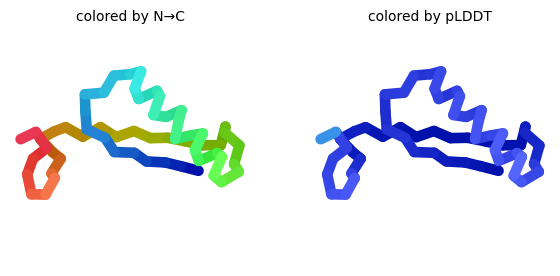

model_2_ptm_seed_0 recycles:3 tol:0.13 pLDDT:97.02 pTMscore:0.77


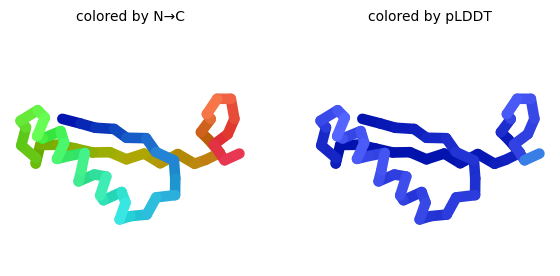

model_3_ptm_seed_0 recycles:3 tol:0.08 pLDDT:97.48 pTMscore:0.78


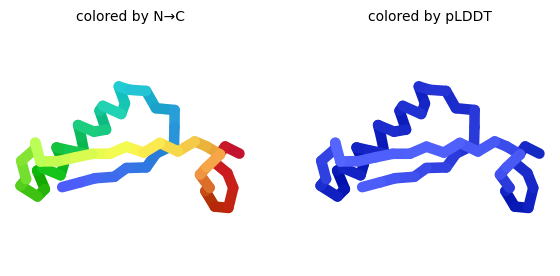

model_4_ptm_seed_0 recycles:3 tol:0.09 pLDDT:96.68 pTMscore:0.77


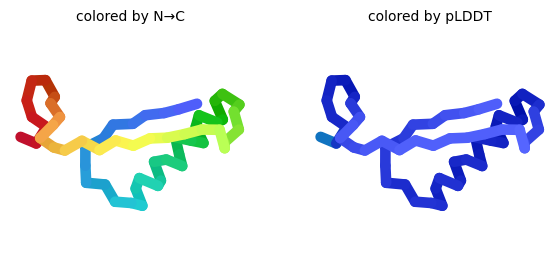

model_5_ptm_seed_0 recycles:3 tol:0.15 pLDDT:96.16 pTMscore:0.77


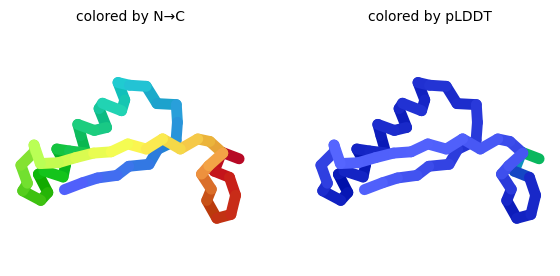

model rank based on pLDDT
rank_1_model_3_ptm_seed_0 pLDDT:97.48
rank_2_model_2_ptm_seed_0 pLDDT:97.02
rank_3_model_4_ptm_seed_0 pLDDT:96.68
rank_4_model_1_ptm_seed_0 pLDDT:96.42
rank_5_model_5_ptm_seed_0 pLDDT:96.16


In [50]:
#@title run alphafold

num_relax = "None"
rank_by = query_rank_by.children[1].value
use_turbo = query_use_turbo.value
max_msa = query_max_msa.children[1].value
max_msa_clusters, max_extra_msa = [int(x) for x in max_msa.split(":")]

show_images = True

num_models = query_num_models.children[1].value
use_ptm = query_use_ptm.value
num_ensemble = query_num_ensemble.children[1].value
max_recycles = query_max_recycles.children[1].value
tol = query_tol.children[1].value
is_training = query_is_training.value
num_samples = query_num_samples.children[1].value

subsample_msa = query_subsample_msa.value

save_pae_json = True
save_tmp_pdb = True


if use_ptm == False and rank_by == "pTMscore":
  print("WARNING: models will be ranked by pLDDT, 'use_ptm' is needed to compute pTMscore")
  rank_by = "pLDDT"

#############################
# delete old files
#############################
for f in os.listdir(output_dir):
  if "rank_" in f:
    os.remove(os.path.join(output_dir, f))

#############################
# homooligomerize
#############################
lengths = [len(seq) for seq in seqs]
msas_mod, deletion_matrices_mod = cf.homooligomerize_heterooligomer(msas, deletion_matrices,
                                                                    lengths, homooligomers)
#############################
# define input features
#############################
def _placeholder_template_feats(num_templates_, num_res_):
  return {
      'template_aatype': np.zeros([num_templates_, num_res_, 22], np.float32),
      'template_all_atom_masks': np.zeros([num_templates_, num_res_, 37, 3], np.float32),
      'template_all_atom_positions': np.zeros([num_templates_, num_res_, 37], np.float32),
      'template_domain_names': np.zeros([num_templates_], np.float32),
      'template_sum_probs': np.zeros([num_templates_], np.float32),
  }

num_res = len(full_sequence)
feature_dict = {}
feature_dict.update(pipeline.make_sequence_features(full_sequence, 'test', num_res))
feature_dict.update(pipeline.make_msa_features(msas_mod, deletion_matrices=deletion_matrices_mod))
if not use_turbo:
  feature_dict.update(_placeholder_template_feats(0, num_res))

def do_subsample_msa(F, random_seed=0):
  '''subsample msa to avoid running out of memory'''
  N = len(F["msa"])
  L = len(F["residue_index"])
  N_ = int(3E7/L)
  if N > N_:
    print(f"whhhaaa... too many sequences ({N}) subsampling to {N_}")
    np.random.seed(random_seed)
    idx = np.append(0,np.random.permutation(np.arange(1,N)))[:N_]
    F_ = {}
    F_["msa"] = F["msa"][idx]
    F_["deletion_matrix_int"] = F["deletion_matrix_int"][idx]
    F_["num_alignments"] = np.full_like(F["num_alignments"],N_)
    for k in ['aatype', 'between_segment_residues',
              'domain_name', 'residue_index',
              'seq_length', 'sequence']:
              F_[k] = F[k]
    return F_
  else:
    return F

################################
# set chain breaks
################################
Ls = []
for seq,h in zip(ori_sequence.split(":"),homooligomers):
  Ls += [len(s) for s in seq.split("/")] * h
Ls_plot = sum([[len(seq)]*h for seq,h in zip(seqs,homooligomers)],[])
feature_dict['residue_index'] = cf.chain_break(feature_dict['residue_index'], Ls)

###########################
# run alphafold
###########################
def parse_results(prediction_result, processed_feature_dict):
  b_factors = prediction_result['plddt'][:,None] * prediction_result['structure_module']['final_atom_mask']
  dist_bins = jax.numpy.append(0,prediction_result["distogram"]["bin_edges"])
  dist_mtx = dist_bins[prediction_result["distogram"]["logits"].argmax(-1)]
  contact_mtx = jax.nn.softmax(prediction_result["distogram"]["logits"])[:,:,dist_bins < 8].sum(-1)

  out = {"unrelaxed_protein": protein.from_prediction(processed_feature_dict, prediction_result, b_factors=b_factors),
         "plddt": prediction_result['plddt'],
         "pLDDT": prediction_result['plddt'].mean(),
         "dists": dist_mtx,
         "adj": contact_mtx}

  if "ptm" in prediction_result:
    out.update({"pae": prediction_result['predicted_aligned_error'],
                "pTMscore": prediction_result['ptm']})
  return out

model_names = ['model_1', 'model_2', 'model_3', 'model_4', 'model_5'][:num_models]
total = len(model_names) * num_samples
with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
  #######################################################################
  # precompile model and recompile only if length changes
  #######################################################################
  if use_turbo:
    name = "model_5_ptm" if use_ptm else "model_5"
    N = len(feature_dict["msa"])
    L = len(feature_dict["residue_index"])
    compiled = (N, L, use_ptm, max_recycles, tol, num_ensemble, max_msa, is_training)
    if "COMPILED" in dir():
      if COMPILED != compiled: recompile = True
    else: recompile = True
    if recompile:
      cf.clear_mem("gpu")
      cfg = config.model_config(name)

      # set size of msa (to reduce memory requirements)
      msa_clusters = min(N, max_msa_clusters)
      cfg.data.eval.max_msa_clusters = msa_clusters
      cfg.data.common.max_extra_msa = max(min(N-msa_clusters,max_extra_msa),1)

      cfg.data.common.num_recycle = max_recycles
      cfg.model.num_recycle = max_recycles
      cfg.model.recycle_tol = tol
      cfg.data.eval.num_ensemble = num_ensemble

      params = data.get_model_haiku_params(name,'./alphafold/data')
      model_runner = model.RunModel(cfg, params, is_training=is_training)
      COMPILED = compiled
      recompile = False

  else:
    cf.clear_mem("gpu")
    recompile = True

  # cleanup
  if "outs" in dir(): del outs
  outs = {}
  cf.clear_mem("cpu")

  #######################################################################
  def report(key):
    pbar.update(n=1)
    o = outs[key]
    line = f"{key} recycles:{o['recycles']} tol:{o['tol']:.2f} pLDDT:{o['pLDDT']:.2f}"
    if use_ptm: line += f" pTMscore:{o['pTMscore']:.2f}"
    print(line)
    if show_images:
      fig = cf.plot_protein(o['unrelaxed_protein'], Ls=Ls_plot, dpi=100)
      plt.show()
      plt.ion()
    if save_tmp_pdb:
      tmp_pdb_path = os.path.join(output_dir,f'unranked_{key}_unrelaxed.pdb')
      pdb_lines = protein.to_pdb(o['unrelaxed_protein'])
      with open(tmp_pdb_path, 'w') as f: f.write(pdb_lines)

  if use_turbo:
    # go through each random_seed
    for seed in range(num_samples):

      # prep input features
      if subsample_msa:
        sampled_feats_dict = do_subsample_msa(feature_dict, random_seed=seed)
        processed_feature_dict = model_runner.process_features(sampled_feats_dict, random_seed=seed)
      else:
        processed_feature_dict = model_runner.process_features(feature_dict, random_seed=seed)

      # go through each model
      for num, model_name in enumerate(model_names):
        name = model_name+"_ptm" if use_ptm else model_name
        key = f"{name}_seed_{seed}"
        pbar.set_description(f'Running {key}')

        # replace model parameters
        params = data.get_model_haiku_params(name, './alphafold/data')
        for k in model_runner.params.keys():
          model_runner.params[k] = params[k]

        # predict
        prediction_result, (r, t) = cf.to(model_runner.predict(processed_feature_dict, random_seed=seed),"cpu")

        # save results
        outs[key] = parse_results(prediction_result, processed_feature_dict)
        outs[key].update({"recycles":r, "tol":t})
        report(key)

        del prediction_result, params
      del sampled_feats_dict, processed_feature_dict

  else:
    # go through each model
    for num, model_name in enumerate(model_names):
      name = model_name+"_ptm" if use_ptm else model_name
      params = data.get_model_haiku_params(name, './alphafold/data')
      cfg = config.model_config(name)
      cfg.data.common.num_recycle = cfg.model.num_recycle = max_recycles
      cfg.model.recycle_tol = tol
      cfg.data.eval.num_ensemble = num_ensemble
      model_runner = model.RunModel(cfg, params, is_training=is_training)

      # go through each random_seed
      for seed in range(num_samples):
        key = f"{name}_seed_{seed}"
        pbar.set_description(f'Running {key}')
        processed_feature_dict = model_runner.process_features(feature_dict, random_seed=seed)
        prediction_result, (r, t) = cf.to(model_runner.predict(processed_feature_dict, random_seed=seed),"cpu")
        outs[key] = parse_results(prediction_result, processed_feature_dict)
        outs[key].update({"recycles":r, "tol":t})
        report(key)

        # cleanup
        del processed_feature_dict, prediction_result

      del params, model_runner, cfg
      cf.clear_mem("gpu")

  # delete old files
  for f in os.listdir(output_dir):
    if "rank" in f:
      os.remove(os.path.join(output_dir, f))

  # Find the best model according to the mean pLDDT.
  model_rank = list(outs.keys())
  model_rank = [model_rank[i] for i in np.argsort([outs[x][rank_by] for x in model_rank])[::-1]]

  # Write out the prediction
  for n,key in enumerate(model_rank):
    prefix = f"rank_{n+1}_{key}"
    pred_output_path = os.path.join(output_dir,f'{prefix}_unrelaxed.pdb')
    fig = cf.plot_protein(outs[key]["unrelaxed_protein"], Ls=Ls_plot, dpi=200)
    plt.savefig(os.path.join(output_dir,f'{prefix}.png'), bbox_inches = 'tight')
    plt.close(fig)

    pdb_lines = protein.to_pdb(outs[key]["unrelaxed_protein"])
    with open(pred_output_path, 'w') as f:
      f.write(pdb_lines)

############################################################
print(f"model rank based on {rank_by}")
for n,key in enumerate(model_rank):
  print(f"rank_{n+1}_{key} {rank_by}:{outs[key][rank_by]:.2f}")

## Refine structures with Amber-Relax (Optional)
Run the cell below and then you will be presented with boxes where you can enter the inputs.

In [52]:
query_num_relax = widgets.HBox([widgets.Label('num_relax:',style=sty),widgets.Dropdown(
    options=["None", "Top1", "Top5", "All"],
    value="None", 
    decription='num_relax:',
    ensure_option=True,
    layout=widgets.Layout(width='60%'))])

display(query_num_relax)

In [53]:
num_relax = query_num_relax.children[1].value
if num_relax == "None":
  num_relax = 0
elif num_relax == "Top1":
  num_relax = 1
elif num_relax == "Top5":
  num_relax = 5
else:
  num_relax = len(model_names) * num_samples

if num_relax > 0:
  if "relax" not in dir():
    # add conda environment to path
    sys.path.append('./colabfold-conda/lib/python3.7/site-packages')

    # import libraries
    from alphafold.relax import relax
    from alphafold.relax import utils

  with tqdm.notebook.tqdm(total=num_relax, bar_format=TQDM_BAR_FORMAT) as pbar:
    pbar.set_description(f'AMBER relaxation')
    for n,key in enumerate(model_rank):
      if n < num_relax:
        prefix = f"rank_{n+1}_{key}"
        pred_output_path = os.path.join(output_dir,f'{prefix}_relaxed.pdb')
        if not os.path.isfile(pred_output_path):
          amber_relaxer = relax.AmberRelaxation(
              max_iterations=0,
              tolerance=2.39,
              stiffness=10.0,
              exclude_residues=[],
              max_outer_iterations=20)
          relaxed_pdb_lines, _, _ = amber_relaxer.process(prot=outs[key]["unrelaxed_protein"])
          with open(pred_output_path, 'w') as f:
            f.write(relaxed_pdb_lines)
        pbar.update(n=1)

## Display 3D structure
Run the cell below and then you will be presented with boxes where you can enter the inputs.

In [57]:
query_rank_num = widgets.HBox([widgets.Label('rank_num:',style=sty),widgets.Dropdown(
    options=[1, 2, 3, 4, 5],
    value=1, 
    decription='rank_num:',
    ensure_option=True,
    layout=widgets.Layout(width='60%'))])
query_color = widgets.HBox([widgets.Label('color:',style=sty),widgets.Dropdown(
    options=["chain", "lDDT", "rainbow"],
    value="lDDT", 
    decription='color:',
    ensure_option=True,
    layout=widgets.Layout(width='60%'))])
query_show_sidechains = widgets.Checkbox(value=False, description="show_sidechains",indent=False)
query_show_mainchains = widgets.Checkbox(value=False, description="show_mainchains",indent=False)

display(query_rank_num, query_color, query_show_sidechains, query_show_mainchains)

Checkbox(value=False, description='show_sidechains', indent=False)

Checkbox(value=False, description='show_mainchains', indent=False)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

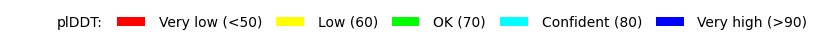

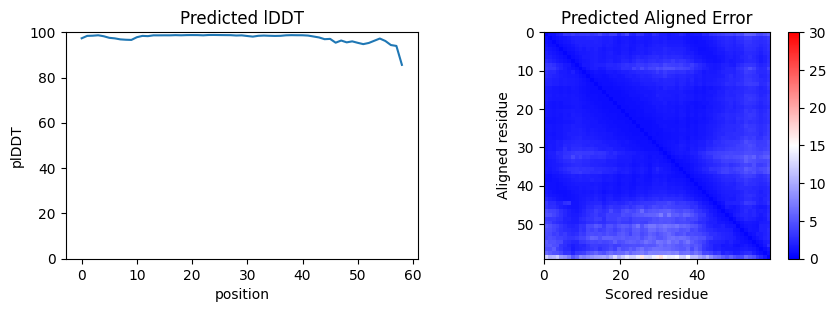

In [58]:
rank_num = query_rank_num.children[1].value
color = query_color.children[1].value
show_sidechains = query_show_sidechains.value
show_mainchains = query_show_mainchains.value

key = model_rank[rank_num-1]
prefix = f"rank_{rank_num}_{key}"
pred_output_path = os.path.join(output_dir,f'{prefix}_relaxed.pdb')
if not os.path.isfile(pred_output_path):
  pred_output_path = os.path.join(output_dir,f'{prefix}_unrelaxed.pdb')

cf.show_pdb(pred_output_path, show_sidechains, show_mainchains, color, Ls=Ls_plot).show()
if color == "lDDT": cf.plot_plddt_legend().show()
if use_ptm:
  cf.plot_confidence(outs[key]["plddt"], outs[key]["pae"], Ls=Ls_plot).show()
else:
  cf.plot_confidence(outs[key]["plddt"], Ls=Ls_plot).show()

## Extra outputs
Run the cell below and then you will be presented with boxes where you can enter the inputs.

In [64]:
query_dpi =  widgets.IntText(
    value=300,
    description='dpi:',
    disabled=False
)
query_save_to_txt = widgets.Checkbox(value=True, description="save_to_txt",indent=False)
query_save_pae_json = widgets.Checkbox(value=True, description="save_pae_json",indent=False)

display(query_dpi, query_save_to_txt, query_save_pae_json)

IntText(value=300, description='dpi:')

Checkbox(value=True, description='save_to_txt', indent=False)

Checkbox(value=True, description='save_pae_json', indent=False)

Save data used to generate contact and distogram plots below to text file (pae values can be found in json file if `use_ptm` is enabled)

predicted alignment error


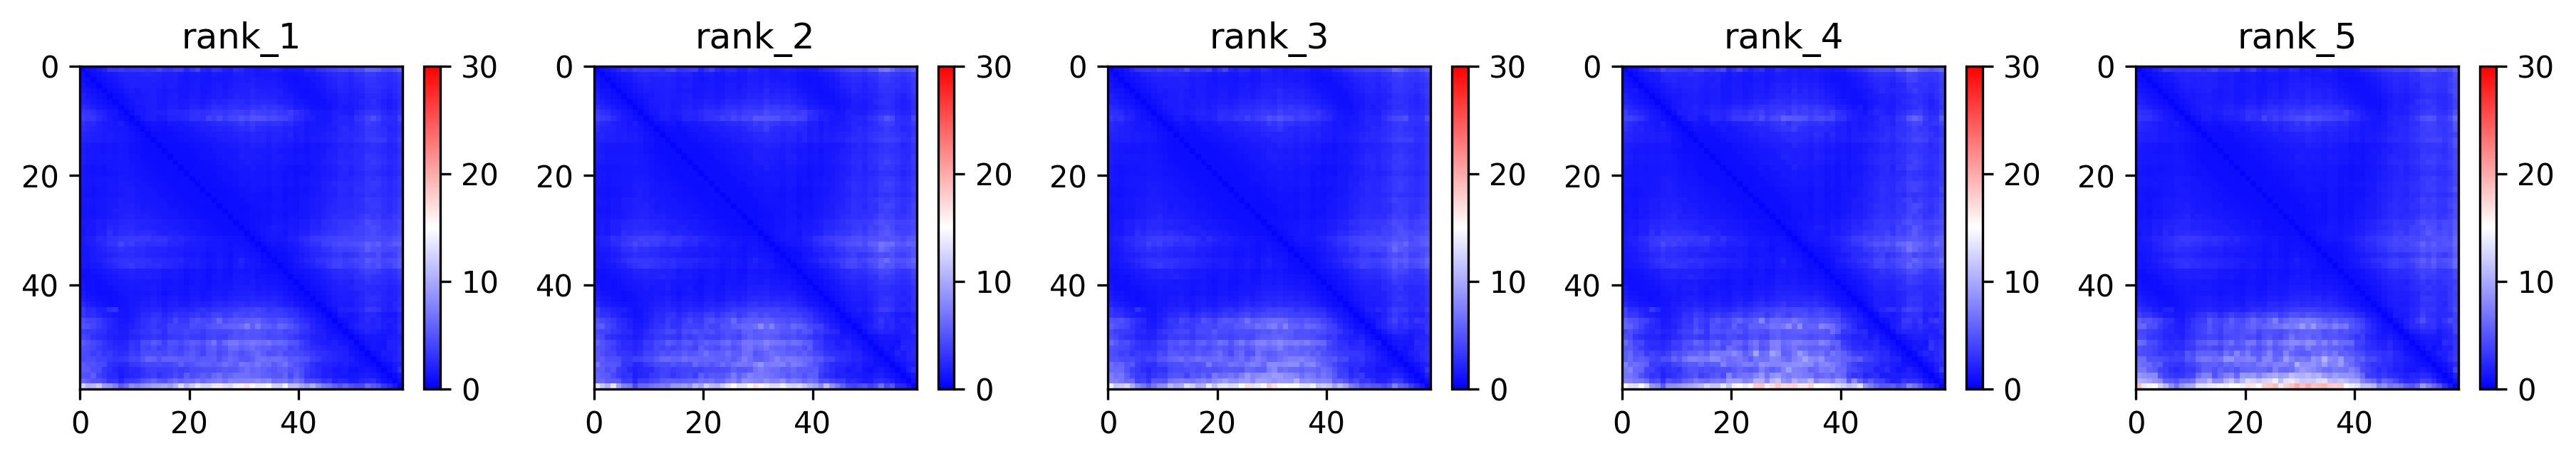

predicted contacts


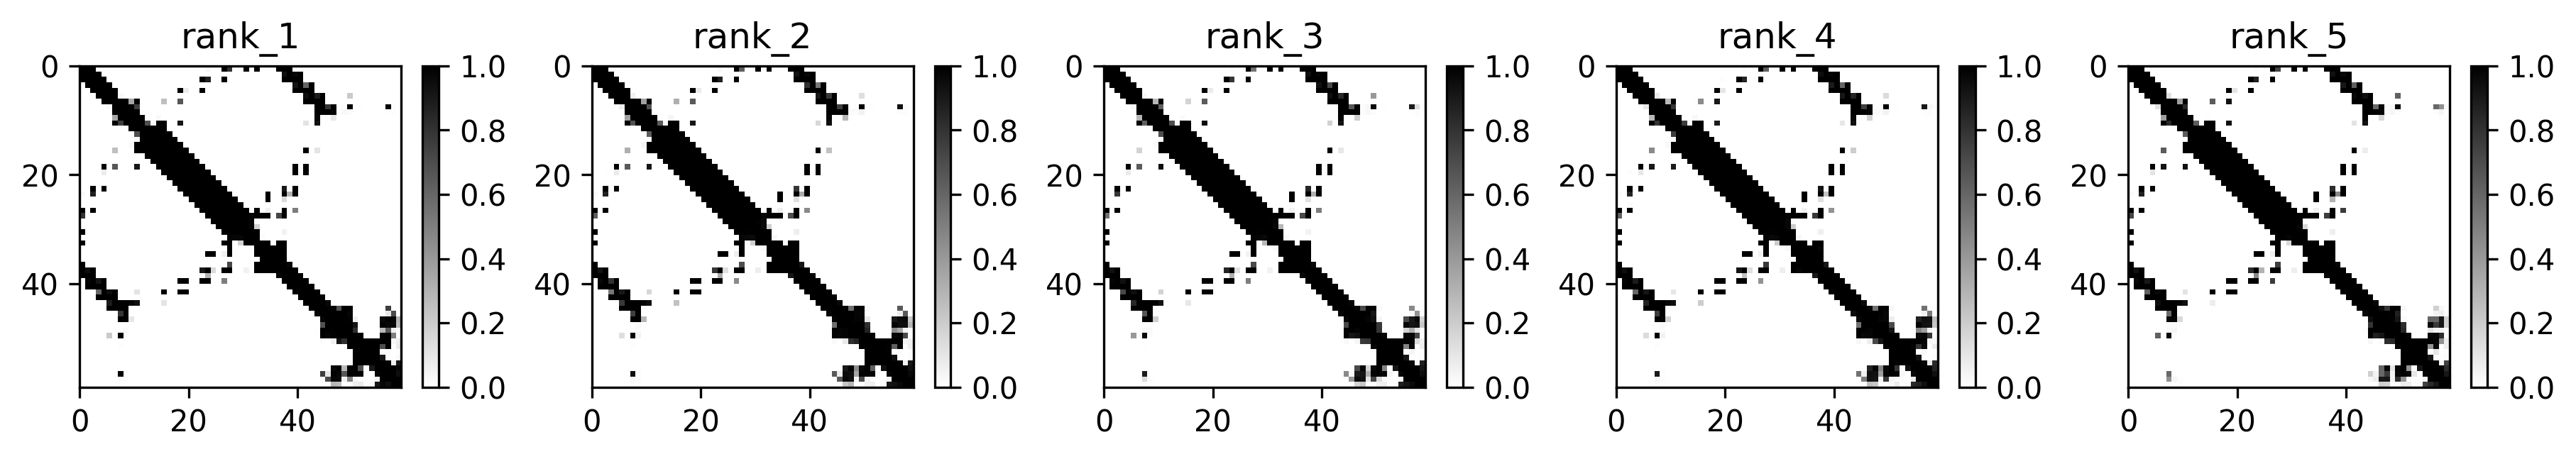

predicted distogram


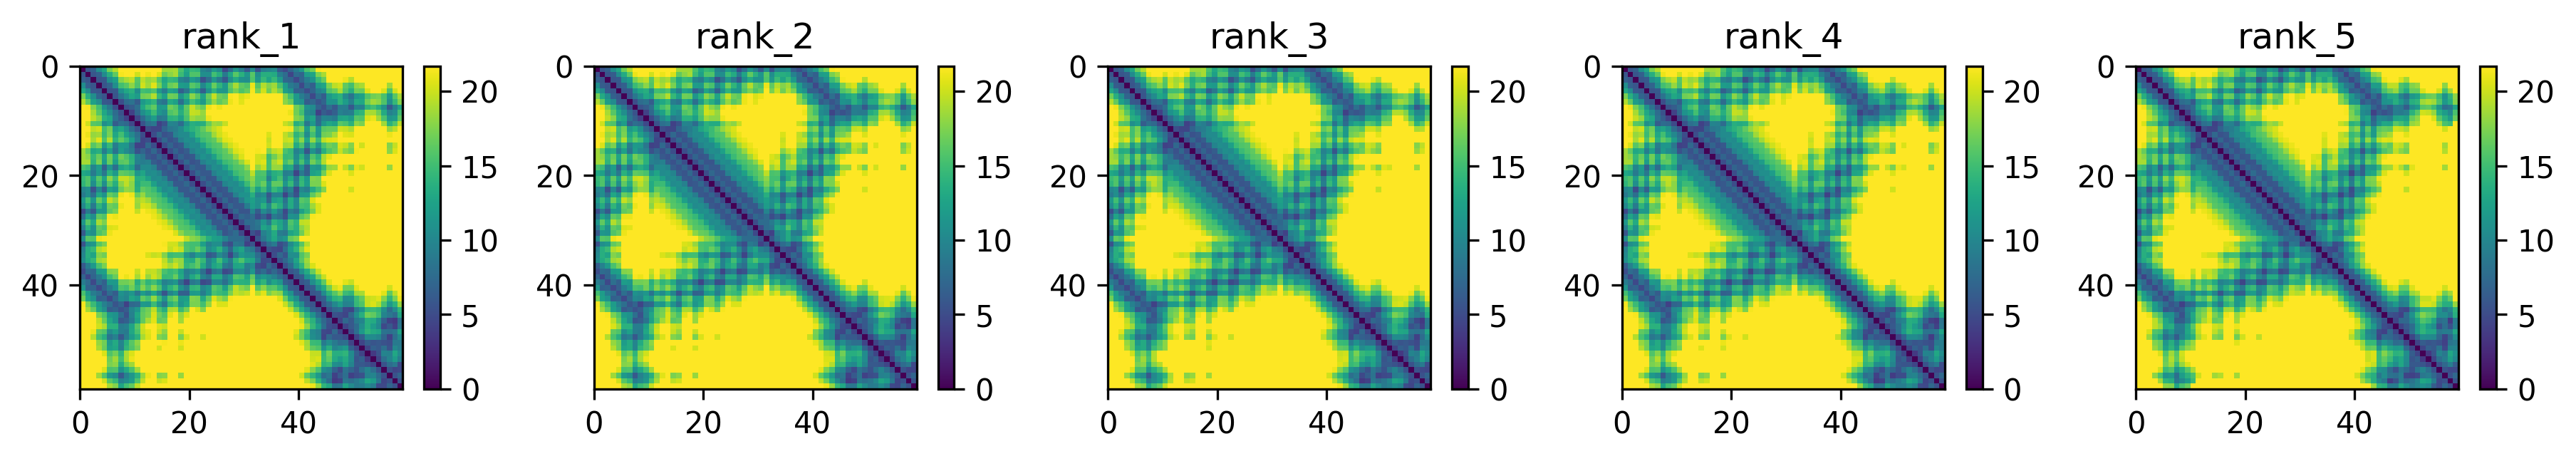

predicted LDDT


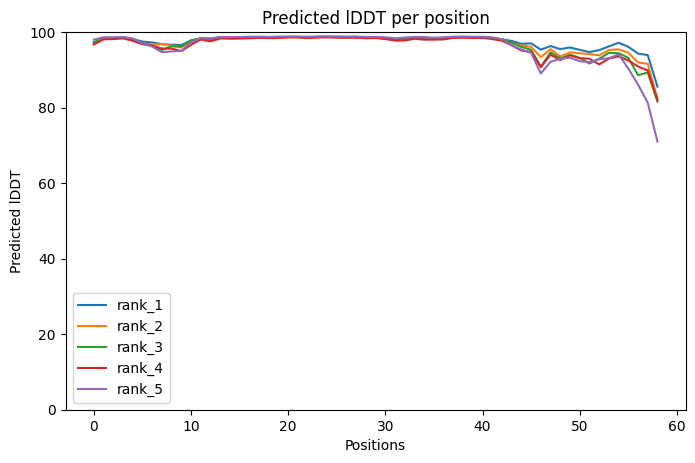

In [65]:
dpi =  query_dpi.value
save_to_txt = query_save_to_txt.value
save_pae_json = query_save_pae_json.value

if use_ptm:
  print("predicted alignment error")
  cf.plot_paes([outs[k]["pae"] for k in model_rank], Ls=Ls_plot, dpi=dpi)
  plt.savefig(os.path.join(output_dir,f'predicted_alignment_error.png'), bbox_inches = 'tight', dpi=np.maximum(200,dpi))
  plt.show()

print("predicted contacts")
cf.plot_adjs([outs[k]["adj"] for k in model_rank], Ls=Ls_plot, dpi=dpi)
plt.savefig(os.path.join(output_dir,f'predicted_contacts.png'), bbox_inches = 'tight', dpi=np.maximum(200,dpi))
plt.show()

print("predicted distogram")
cf.plot_dists([outs[k]["dists"] for k in model_rank], Ls=Ls_plot, dpi=dpi)
plt.savefig(os.path.join(output_dir,f'predicted_distogram.png'), bbox_inches = 'tight', dpi=np.maximum(200,dpi))
plt.show()

print("predicted LDDT")
cf.plot_plddts([outs[k]["plddt"] for k in model_rank], Ls=Ls_plot, dpi=dpi)
plt.savefig(os.path.join(output_dir,f'predicted_LDDT.png'), bbox_inches = 'tight', dpi=np.maximum(200,dpi))
plt.show()

def do_save_to_txt(filename, adj, dists):
  adj = np.asarray(adj)
  dists = np.asarray(dists)
  L = len(adj)
  with open(filename,"w") as out:
    out.write("i\tj\taa_i\taa_j\tp(cbcb<8)\tmaxdistbin\n")
    for i in range(L):
      for j in range(i+1,L):
        if dists[i][j] < 21.68 or adj[i][j] >= 0.001:
          line = f"{i+1}\t{j+1}\t{full_sequence[i]}\t{full_sequence[j]}\t{adj[i][j]:.3f}"
          line += f"\t>{dists[i][j]:.2f}" if dists[i][j] == 21.6875 else f"\t{dists[i][j]:.2f}"
          out.write(f"{line}\n")

for n,key in enumerate(model_rank):
  if save_to_txt:
    txt_filename = os.path.join(output_dir,f'rank_{n+1}_{key}.raw.txt')
    do_save_to_txt(txt_filename,adj=outs[key]["adj"],dists=outs[key]["dists"])

  if use_ptm and save_pae_json:
    pae = outs[key]["pae"]
    max_pae = pae.max()
    # Save pLDDT and predicted aligned error (if it exists)
    pae_output_path = os.path.join(output_dir,f'rank_{n+1}_{key}_pae.json')
    # Save predicted aligned error in the same format as the AF EMBL DB
    rounded_errors = np.round(np.asarray(pae), decimals=1)
    indices = np.indices((len(rounded_errors), len(rounded_errors))) + 1
    indices_1 = indices[0].flatten().tolist()
    indices_2 = indices[1].flatten().tolist()
    pae_data = json.dumps([{
        'residue1': indices_1,
        'residue2': indices_2,
        'distance': rounded_errors.flatten().tolist(),
        'max_predicted_aligned_error': max_pae.item()
    }],
                          indent=None,
                          separators=(',', ':'))
    with open(pae_output_path, 'w') as f:
      f.write(pae_data)
#%%